<a href="https://colab.research.google.com/github/Ayushma00/Ayushma00/blob/master/Untitled3b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Library

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa
from librosa import display
%matplotlib inline
import pickle

### Audio Data Preprocessing
- Converting audio into frequency domain
- Applying FFT 
- Sprectrum Analysis 

In [8]:
def librosa_spec(path):    
    # Size of the FFT, which will also be used as the window length
    n_fft=2048

    # Step or stride between windows. If the step is smaller than the window lenght, the windows will overlap
    hop_length=512

    # Load sample audio file
    y, sr = librosa.load(path,sr=44100, mono = True, offset = 0.0, duration= None)
    y_trim,_=librosa.effects.trim(y, frame_length=44100, top_db=5)

#     print("The sound file  is of : "+str(round((len(y)/ sr),3))+ " seconds")
    # Calculate the spectrogram as the square of the complex magnitude of the STFT
    spectrogram_librosa = np.abs(librosa.stft(
        y_trim, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window='hann')) ** 2
    arr = np.zeros((1025,160))
    arr = arr + 1e-9
    if(spectrogram_librosa.shape[1]>=160):
        spectrogram_librosa= spectrogram_librosa[:,:160]
    arr[:,:spectrogram_librosa.shape[1]] = spectrogram_librosa
    spectrogram_librosa_db = librosa.amplitude_to_db(arr, ref=np.max)
    arr1 = np.transpose(spectrogram_librosa_db)
#     librosa.display.specshow(spectrogram_librosa_db, sr=sr, y_axis='log', x_axis='time', hop_length=hop_length)
#     plt.title('Reference power spectrogram')
#     plt.colorbar(format='%+2.0f dB')
#     plt.tight_layout()
#     plt.show()
    return arr1

- Acquiring the Audio Datasets

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
X=[]
y=[]
import os
sound_dir='/content/drive/My Drive/sound first'
for root,dirs,files in os.walk(sound_dir):
    for file in files:
        if file.endswith('wav'):
            path = os.path.join(root,file)
            X.append(librosa_spec(path))
            y.append(os.path.basename(os.path.dirname(path)).replace(" ","_"))

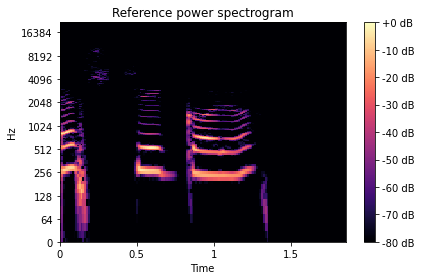

ग्यास_चेक_गर


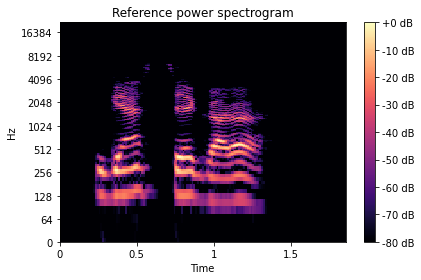

ग्यास_चेक_गर


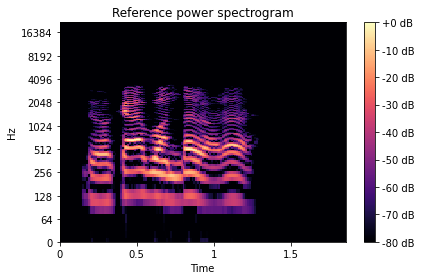

ढोका_बन्द_गर


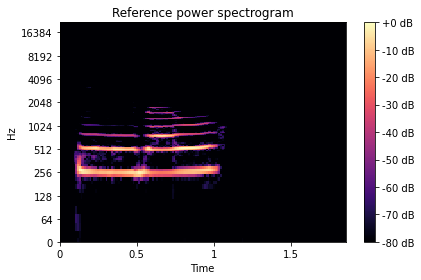

बत्ती_निबाउ


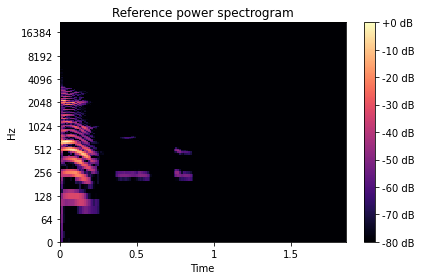

बत्ती_निबाउ


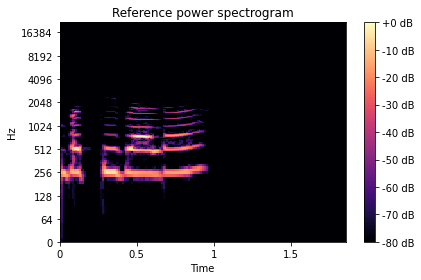

बत्ती_बाल


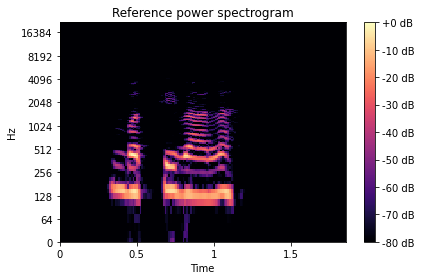

बत्ती_बाल


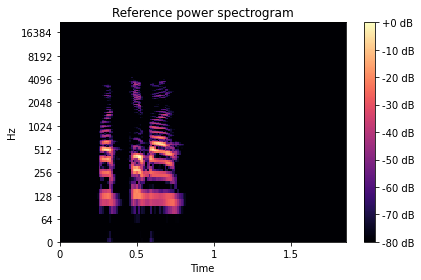

बत्ती_बाल


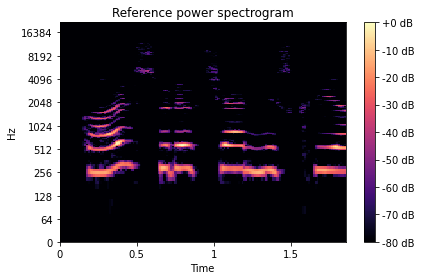

घर_सुरक्षा_निष्क्रिय_गर


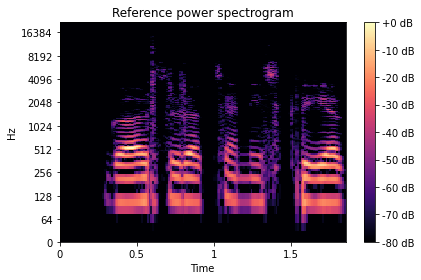

घर_सुरक्षा_निष्क्रिय_गर


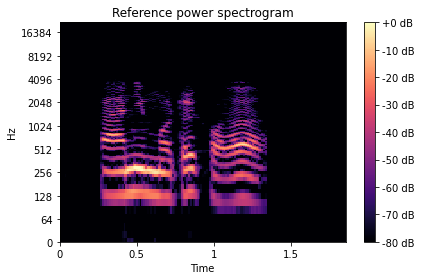

पानी_मोटर_खोल


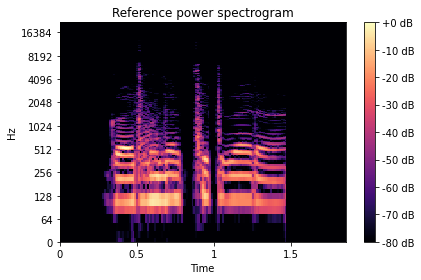

घर_सुरक्षित_गर


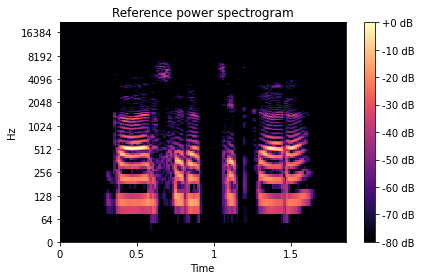

घर_सुरक्षित_गर


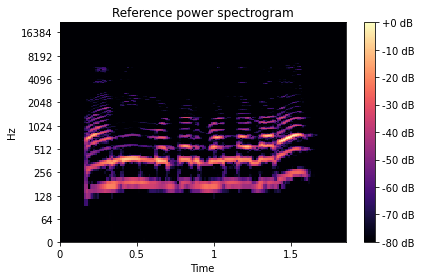

पानी_मोटर_बन्द_गर


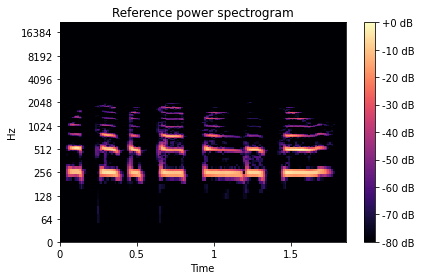

कोठाको_तापक्रम_देखाउ


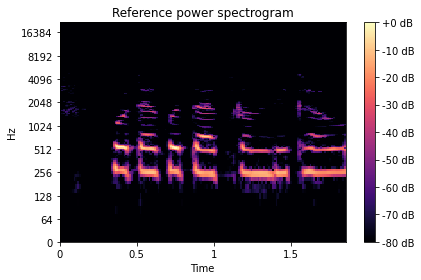

कोठाको_तापक्रम_देखाउ


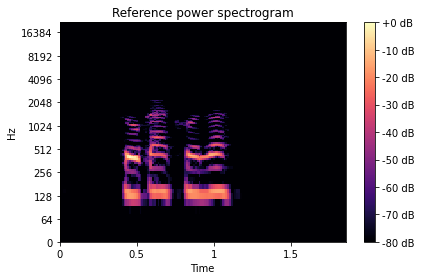

ढोका_खोल


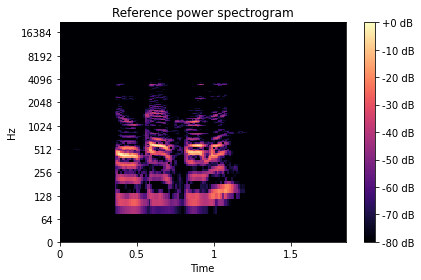

ढोका_खोल


In [45]:
for i in range(len(X)):
    if i%10==0:
        librosa.display.specshow(X[i].transpose(), sr=44100, y_axis='log', x_axis='time', hop_length=512)
        plt.title('Reference power spectrogram')
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()
        print(y[i])

In [12]:
X2=X3=X4=X5=X.copy()
y2=y3=y4=y5=y.copy()

In [13]:
X1=X2+X3+X4+X5
y1=y2+y3+y4+y5

In [14]:
X1 = np.array(X1)
y1 = np.array(y1)
y1=y1.reshape(-1, 1)

In [16]:
print(X1.shape)
print(y1.shape)

(692, 160, 1025)
(692, 1)


In [ ]:
import pickle as pkl
with open('Xdata.pkl','rb') as f:
    X = pkl.load(f)
    print(len(X))
    
with open('ydata.pkl','rb') as f:
    y = pkl.load(f)
    print(len(y))  

### Applying One hot encoding to the y labels

In [17]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False,handle_unknown="ignore")
y1=ohe.fit_transform(y1)

In [18]:
from sklearn.preprocessing import MinMaxScaler
ms = MinMaxScaler()
for i in range(X1.shape[0]):
    X1[i]=ms.fit_transform(X1[i])

In [19]:
print(X1.shape)
print(y1.shape)

(692, 160, 1025)
(692, 10)


### Training and Testing Datasets

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1,y1,test_size=0.3,random_state=141)

In [66]:
X_train.shape
X_test.shape

(208, 160, 1025)

In [21]:
X_train=X_train.reshape(-1,160,1025,1)
X_test=X_test.reshape(-1,160,1025,1)

In [22]:
X_test.shape

(208, 160, 1025, 1)

### CNN-LSTM Model Development

In [23]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout, GRU,Conv2D,Conv1D, MaxPool2D,Flatten,TimeDistributed,Activation
from keras.callbacks import ReduceLROnPlateau

In [24]:
model = Sequential()
model.add(TimeDistributed(Conv1D(32,7, padding='same', strides = 2),
            input_shape=(160, 1025, 1)))
model.add(Activation('relu'))
model.add(TimeDistributed(Conv1D(64, 5, padding='same', strides = 2)))
model.add(Activation('relu'))

    #model.add(TimeDistributed(MaxPooling2D((2,2), data_format = 'channels_first', name='pool1')))
    
model.add(TimeDistributed(Conv1D(128, 5, padding='same', strides = 2)))
model.add(Activation('relu'))    
model.add(TimeDistributed(Flatten()))  
    #model.add(TimeDistributed(Dense(512, name="first_dense" )))
    
    #model.add(LSTM(num_classes, return_sequences=True))
model.add(LSTM(units=64,return_sequences=True))
model.add(LSTM(units=32,return_sequences=False))

model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 160, 513, 32)      256       
_________________________________________________________________
activation (Activation)      (None, 160, 513, 32)      0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 160, 257, 64)      10304     
_________________________________________________________________
activation_1 (Activation)    (None, 160, 257, 64)      0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 160, 129, 128)     41088     
_________________________________________________________________
activation_2 (Activation)    (None, 160, 129, 128)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 160, 16512)        0

In [72]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 160, 513, 32)      256       
_________________________________________________________________
activation (Activation)      (None, 160, 513, 32)      0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 160, 257, 64)      10304     
_________________________________________________________________
activation_1 (Activation)    (None, 160, 257, 64)      0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 160, 129, 128)     41088     
_________________________________________________________________
activation_2 (Activation)    (None, 160, 129, 128)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 160, 16512)        0

In [ ]:
# model = Sequential()
# model.add(LSTM(units=64,return_sequences=True,input_shape = (160,1025)))
# model.add(LSTM(units=32,return_sequences=True))
# model.add(LSTM(units=16,return_sequences=False))
# model.add(Dense(y_train.shape[1], activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])
# model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 160, 64)           279040    
_________________________________________________________________
lstm_4 (LSTM)                (None, 160, 32)           12416     
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
Total params: 294,762
Trainable params: 294,762
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_test.shape

(208, 10)

### Model Training

In [26]:
MAX_PATIENT=12
MAX_EPOCHS=100
MAX_BATCH=64

In [27]:
callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1)]
history=model.fit(X_train, y_train, 
                  batch_size=MAX_BATCH, 
                  
                  epochs=MAX_EPOCHS,
                  verbose=1,
                  validation_data=(X_test, y_test),
                  )

Epoch 1/100
8/8 [==============================] - 150s 19s/step - loss: 2.2511 - acc: 0.1983 - val_loss: 2.1285 - val_acc: 0.2596
Epoch 2/100
8/8 [==============================] - 153s 19s/step - loss: 2.0676 - acc: 0.2128 - val_loss: 2.0137 - val_acc: 0.2740
Epoch 3/100
8/8 [==============================] - 152s 19s/step - loss: 1.9254 - acc: 0.3223 - val_loss: 1.9434 - val_acc: 0.3029
Epoch 4/100
8/8 [==============================] - 152s 19s/step - loss: 1.8266 - acc: 0.3905 - val_loss: 1.8435 - val_acc: 0.3558
Epoch 5/100
8/8 [==============================] - 151s 19s/step - loss: 1.7076 - acc: 0.4421 - val_loss: 1.7319 - val_acc: 0.4087
Epoch 6/100
8/8 [==============================] - 151s 19s/step - loss: 1.5875 - acc: 0.4711 - val_loss: 1.6491 - val_acc: 0.4375
Epoch 7/100
8/8 [==============================] - 151s 19s/step - loss: 1.5419 - acc: 0.4793 - val_loss: 1.7219 - val_acc: 0.4375
Epoch 8/100
8/8 [==============================] - 151s 19s/step - loss: 1.5330 - a

In [ ]:
# model = load_model("ourmodel.h5")

In [29]:
model.save("cnn_lstmmodel.h5")

### Model Testing  and Evaluations

In [ ]:
import sounddevice as sd
from scipy.io.wavfile import write
from IPython.display import Audio
def librosa_test(y,sr):    
    # Size of the FFT, which will also be used as the window length
    n_fft=2048

    # Step or stride between windows. If the step is smaller than the window lenght, the windows will overlap
    hop_length=512
    y_trim,_=librosa.effects.trim(y, frame_length=44100, top_db=5)
    
    # Load sample audio file
#     print("The sound file  is of : "+str(round((len(y)/ sr),3))+ " seconds")
    # Calculate the spectrogram as the square of the complex magnitude of the STFT
    spectrogram_librosa = np.abs(librosa.stft(
        y_trim, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window='hann')) ** 2
    arr = np.zeros((1025,160))
    arr = arr + 1e-9
    if(spectrogram_librosa.shape[1]>=160):
        spectrogram_librosa= spectrogram_librosa[:,:160]                       
    arr[:,:spectrogram_librosa.shape[1]] = spectrogram_librosa
    spectrogram_librosa_db = librosa.amplitude_to_db(arr, ref=np.max)
    arr1 = np.transpose(spectrogram_librosa_db)
    librosa.display.specshow(spectrogram_librosa_db, sr=sr, y_axis='log', x_axis='time', hop_length=hop_length)
    plt.title('Reference power spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()
    return arr1


In [ ]:
sr = 44100  # Sample rate
seconds = 4  # Duration of recording
myrecording = sd.rec(int(seconds * sr), samplerate=sr, channels=1)
sd.wait()  # Wait until recording is finished
myrecording=myrecording.reshape(myrecording.shape[0],)
Audio(myrecording, rate=sr)

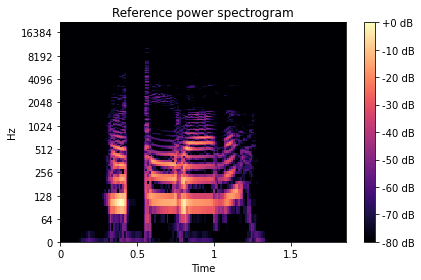

[[0.03007843 0.00252373 0.00151807 0.55230314 0.00169083 0.11459737
  0.2525758  0.00092655 0.02051535 0.02327062]]


In [ ]:
sample = librosa_test(myrecording,sr)
sample = ms.fit_transform(sample)
sample=sample.reshape(1,160,1025)
pred=model.predict(sample)
print(pred)
pred = pred == pred.max()

In [ ]:
ohe.inverse_transform(np.round(pred))

array([['open_the_door']], dtype='<U22')

In [ ]:
# model.save('ourmodel.h5',history) 

In [ ]:
import pickle

In [ ]:
#  pickle.dump(ohe,open('ohe_one_two.pkl','wb'))

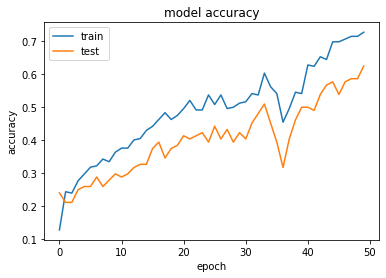

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

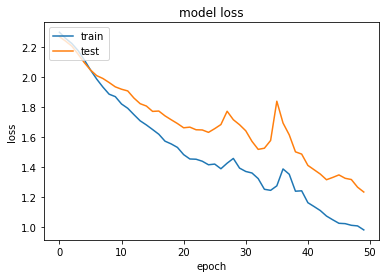

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()